# The bootstrap cannot be this good, can it?

Or, the Delta Method cannot be that conservative, can it?

**Problem**: Delta Method giving very wide confidence interval

**Hypothesis**: Due to the way the gradient is calculated in DM, we divide by square of probability of conversion in control group. Low conversion rates lead to large variance and confidence intervales.

I show this here.

In [2]:
from typing import Dict
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import bootstrap

warnings.filterwarnings('ignore')

rng = np.random.default_rng(1312)

In [ ]:
def delta_se(treatment: np.ndarray[float], control: np.ndarray[float]) -> Dict[str, float]:
    """
    Calculate standard error of relative change (treatment - control) / control with Delta Method
    for binary conversion vectors using delta method. Optionally calculate elasticity.
    """ 
    # Sample sizes
    n_t = len(treatment)
    n_c = len(control)
    
    # Sample proportions
    p_t = np.mean(treatment)
    p_c = np.mean(control)

    if p_c == 0:
        # Return Not a Number (NaN) for all metrics
        return {
            'relative_change': np.nan,
            'se': np.nan,
            'ci_low': np.nan,
            'ci_high': np.nan
        }
    
    # Relative change estimate
    relative_change = (p_t - p_c) / p_c
    
    # Delta method variance calculation
    # Var(θ) = (1/n_c) * [p_t(1-p_t)/p_c^2] + (1/n_c) * [(1-p_c)(p_t-p_c)^2/p_c^3]
    # when n_t = n_c = n, otherwise use separate terms
    
    var_term1 = p_t * (1 - p_t) / (n_t * p_c**2)
    var_term2 = p_t**2 * (1 - p_c) / (n_c * p_c**3)

    variance = var_term1 + var_term2
    standard_error = np.sqrt(variance)
    
    CI_low = relative_change - 1.96*standard_error
    CI_high = relative_change + 1.96*standard_error
        
    return {
            'relative_change': relative_change,
            'se': standard_error,
            'ci_low': CI_low,
            'ci_high': CI_high
    }

In [30]:
def relative_change_statistic(treatment: np.ndarray, control: np.ndarray) -> float:
    """Calculates the relative change: (mean(t) - mean(c)) / mean(c)"""
    p_c = np.mean(control)
    if p_c == 0:
        return np.nan 
    
    p_t = np.mean(treatment)
    return (p_t - p_c) / p_c

### A single example

Let's compare the confidence interval widths for both Delta Method and Bootstrap estimators

In [ ]:
samples_per_variant = 10000
baseline_cr = 0.015
relative_treatment_effect = 0.0
treatment_cr = baseline_cr * (1 + relative_treatment_effect)
theta_estimates = []
dm_ci_width_estimates = []
dm_contains_truth = []
bootstrap_theta_estimates = []
bs_ci_width_estimates = []
bs_contains_truth = []

for i in range(1000):

    control_conversions = rng.binomial(1, baseline_cr, samples_per_variant)
    treatment_conversions = rng.binomial(1, treatment_cr, samples_per_variant)

    dm_estimates = delta_se(treatment_conversions, control_conversions)

    theta_estimates.append(dm_estimates['relative_change'])
    dm_ci_width_estimates.append(dm_estimates['ci_high'] - dm_estimates['ci_low'])
    if abs(dm_estimates['relative_change'] - relative_treatment_effect) < (dm_estimates['ci_high'] - dm_estimates['ci_low']) / 2:
        dm_contains_truth.append(True)
    else:
        dm_contains_truth.append(False)

    data_tuple = (treatment_conversions, control_conversions)

    bs_result = bootstrap(
        data=data_tuple,
        statistic=relative_change_statistic,
        n_resamples=1000,
        method='BCa',
        random_state=rng
    )
    bs_ci = bs_result.confidence_interval
    bs_ci_width = bs_ci.high - bs_ci.low
    point_estimate = relative_change_statistic(treatment_conversions, control_conversions)

    bootstrap_theta_estimates.append(point_estimate)
    bs_ci_width_estimates.append(bs_ci_width)

    if abs(point_estimate - relative_treatment_effect) < (bs_ci_width) / 2:
        bs_contains_truth.append(True)
    else:
        bs_contains_truth.append(False)

print("=" * 50)
print("\t\t Delta Method")
print("=" * 50)
print(f"The average estimate is {np.mean(theta_estimates):.3f}")
print(f"The average CI width is {np.mean(dm_ci_width_estimates):.3f}")
print(f"The CI contains the truth {100*np.mean(dm_contains_truth):.3f}% of the time")

print("=" * 50)
print("\t\t Bootstrap estimates")
print("=" * 50)
print(f"The average estimate is {np.mean(bootstrap_theta_estimates):.3f}")
print(f"The average CI width is {np.mean(bs_ci_width_estimates):.3f}")
print(f"The CI contains the truth {100*np.mean(bs_contains_truth):.3f}% of the time")

print("\n")
print(f"The true relative treatment effect is {relative_treatment_effect}")

		 Delta Method
The average estimate is 0.006
The average CI width is 0.452
The CI contains the truth 90.000% of the time
		 Bootstrap estimates
The average estimate is 0.006
The average CI width is 0.432
The CI contains the truth 86.000% of the time


The true relative treatment effect is 0.0


Now you see it.

Now let's do this over and over again, for different conversion rates

In [ ]:
delta_method_mean = []
delta_method_ci_width = []
delta_method_calibration = []
bootstrap_mean = []
bootstrap_ci_width = []
bootstrap_calibration = []

baseline_conversion_rate_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.35, 0.5]

for baseline_cr in baseline_conversion_rate_list:
    treatment_cr = baseline_cr * (1 + relative_treatment_effect)

    theta_estimates = []
    dm_ci_width_estimates = []
    dm_contains_truth = []
    bootstrap_theta_estimates = []
    bs_ci_width_estimates = []
    bs_contains_truth = []

    for i in range(1000):

        control_conversions = rng.binomial(1, baseline_cr, samples_per_variant)
        treatment_conversions = rng.binomial(1, treatment_cr, samples_per_variant)

        dm_estimates = delta_se(treatment_conversions, control_conversions)

        theta_estimates.append(dm_estimates['relative_change'])
        dm_ci_width_estimates.append(dm_estimates['ci_high'] - dm_estimates['ci_low'])
        if abs(dm_estimates['relative_change'] - relative_treatment_effect) < (dm_estimates['ci_high'] - dm_estimates['ci_low']) / 2:
            dm_contains_truth.append(True)
        else:
            dm_contains_truth.append(False)

        data_tuple = (treatment_conversions, control_conversions)

        bs_result = bootstrap(
            data=data_tuple,
            statistic=relative_change_statistic,
            n_resamples=2000,
            method='BCa',
            random_state=rng
        )
        bs_ci = bs_result.confidence_interval
        bs_ci_width = bs_ci.high - bs_ci.low
        point_estimate = relative_change_statistic(treatment_conversions, control_conversions)

        bootstrap_theta_estimates.append(point_estimate)
        bs_ci_width_estimates.append(bs_ci_width)

        if abs(point_estimate - relative_treatment_effect) < (bs_ci_width) / 2:
            bs_contains_truth.append(True)
        else:
            bs_contains_truth.append(False)

    delta_method_mean.append(np.mean(theta_estimates))
    delta_method_ci_width.append(np.mean(dm_ci_width_estimates))
    delta_method_calibration.append(np.mean(dm_contains_truth))
    bootstrap_mean.append(np.mean(bootstrap_theta_estimates))
    bootstrap_ci_width.append(np.mean(bs_ci_width_estimates))
    bootstrap_calibration.append(np.mean(bs_contains_truth))

df_bs_dm = pd.DataFrame(
    {'cr': baseline_conversion_rate_list,
     'dm_mean': delta_method_mean,
     'dm_ci_w': delta_method_ci_width,
     'dm_calibration' : delta_method_calibration,
     'bs_mean': bootstrap_mean,
     'bs_ci_w': bootstrap_ci_width,
     'bs_calibration': bootstrap_calibration}
)

In [33]:
df_bs_dm

,cr,dm_mean,dm_ci_w,dm_calibration,bs_mean,bs_ci_w,bs_calibration
0,0.01,0.001531,0.557811,0.900000,0.001531,0.491733,0.866667
1,0.02,0.006455,0.391496,0.966667,0.006455,0.365897,0.933333
2,0.05,0.009714,0.244959,0.900000,0.009714,0.202816,0.833333
3,0.10,-0.001074,0.167086,1.000000,-0.001074,0.140322,0.933333
4,0.20,-0.011679,0.109423,0.900000,-0.011679,0.087791,0.833333
5,0.35,0.005182,0.076055,0.866667,0.005182,0.066086,0.833333
6,0.50,0.000263,0.055416,0.933333,0.000263,0.049339,0.900000


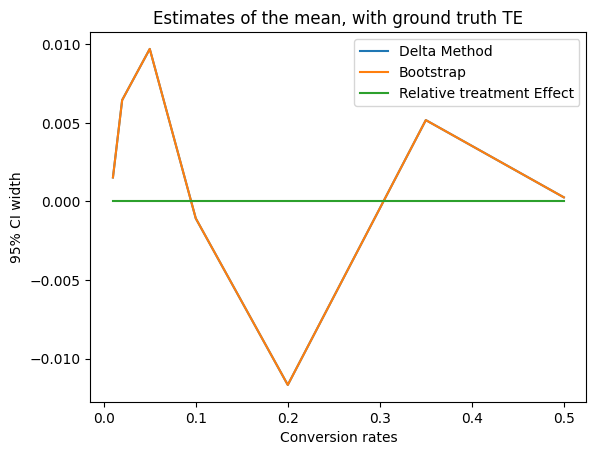

In [ ]:
plt.plot(
    df_bs_dm.cr,
    df_bs_dm.dm_mean,
    label='Delta Method'
)
plt.plot(
    df_bs_dm.cr,
    df_bs_dm.bs_mean,
    label='Bootstrap'
)
plt.plot(
    df_bs_dm.cr,
    [relative_treatment_effect] * len(df_bs_dm.cr),
    label='Relative treatment Effect'
)
plt.title("Estimates of the mean, with ground truth TE")
plt.xlabel("Mean estimates")
plt.ylabel("95% CI width")
plt.legend()

Eppo uses the [Delta Method](https://docs.geteppo.com/statistics/confidence-intervals/statistical-nitty-gritty/#frequentist-analysis)

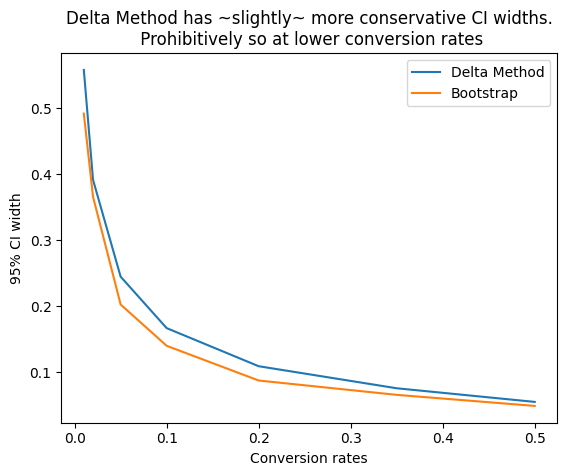

In [39]:
plt.plot(
    df_bs_dm.cr,
    df_bs_dm.dm_ci_w,
    label='Delta Method'
)
plt.plot(
    df_bs_dm.cr,
    df_bs_dm.bs_ci_w,
    label='Bootstrap'
)
plt.title("Delta Method has ~slightly~ more conservative CI widths.\n Prohibitively so at lower conversion rates")
plt.xlabel("Conversion rates")
plt.ylabel("95% CI width")
plt.legend()

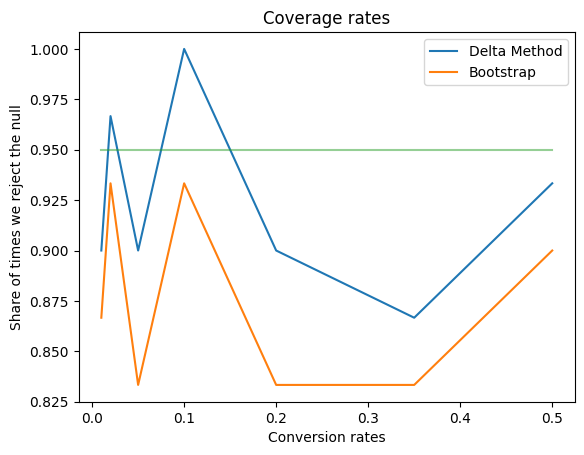

In [40]:
plt.plot(
    df_bs_dm.cr,
    df_bs_dm.dm_calibration,
    label='Delta Method'
)
plt.plot(
    df_bs_dm.cr,
    df_bs_dm.bs_calibration,
    label='Bootstrap'
)
plt.plot(
    df_bs_dm.cr,
    [0.95] * df_bs_dm.shape[0],
    alpha=0.5
)
plt.title("Coverage rates")
plt.xlabel("Conversion rates")
plt.ylabel("Share of times we reject the null")
plt.legend()